# NormSense: Full Pipeline

This notebook runs the complete NormSense pipeline end-to-end:

1. **Phase 1: Dataset & prompts**
2. **Phase 2: Model responses (HF local models)**
3. **Phase 3: LLM-as-a-Judge scoring**
4. **Phase 4: Aggregation of scores**
5. **Phase 5: Plots / figures**
6. **Phase 6: Qualitative error analysis**

The core implementation lives in the `src/normsense/` package and `scripts/` folder.
This notebook calls that code and displays results.

In [35]:
import sys, os, pathlib

# Detect Colab
try:
    import google.colab
    IN_COLAB = True
    print("✔ Running in Google Colab")
except:
    IN_COLAB = False
    print("✔ Not running in Colab")

# -----------------------------
# If running in Colab → CLONE REPO
# -----------------------------
if IN_COLAB:
    REPO_URL = "https://github.com/bkhalil7/normsense.git"
    REPO_NAME = "normsense"

    # Clone repo fresh
    if not pathlib.Path(f"/content/{REPO_NAME}").exists():
        print("📥 Cloning repository...")
        !git clone "$REPO_URL" /content/$REPO_NAME
    else:
        print("🔄 Repo already exists — pulling latest changes")
        %cd /content/$REPO_NAME
        !git pull
        %cd /content

    # Move into repo directory
    %cd /content/$REPO_NAME

    # Install dependencies
    print("📦 Installing dependencies...")
    !pip install -r requirements.txt

    # Add src/ to Python path
    sys.path.append("/content/normsense/src")

    ROOT = pathlib.Path("/content/normsense")

else:
    # LOCAL NOTEBOOK MODE
    ROOT = pathlib.Path.cwd().parents[0]
    sys.path.append(str(ROOT / "src"))
    print("Local ROOT:", ROOT)

print("ROOT directory set to:", ROOT)


✔ Running in Google Colab
🔄 Repo already exists — pulling latest changes
/content/normsense
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 20 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (20/20), 7.97 KiB | 1.99 MiB/s, done.
From https://github.com/bkhalil7/normsense
   6e678c6..0e6d84f  main       -> origin/main
Updating 6e678c6..0e6d84f
Fast-forward
 list[Scenario]                            |   0
 notepad                                   |   0
 src/normsense/models/__init__.py          |   1 +
 src/normsense/models/anthropic_wrapper.py |  87 +++++++++++++++++++++
 src/normsense/models/base.py              |  29 +++++++
 src/normsense/models/huggingface_local.py | 101 ++++++++++++++++++++++++
 src/normsense/models/open_weight_http.py  | 123 ++++++++++++++++++++++++++++++
 src/normsense/models/openai_wrapper.py    |  80 +++++++++++++++++++
 8 files cha

In [36]:
# ----------------------------------------
# Shared utilities used in Phases 1–6
# (ROOT and SRC_DIR are already set by the Colab setup cell)
# ----------------------------------------
import subprocess
from pathlib import Path
import sys
import os

# Confirm ROOT is set (comes from Colab setup)
print("ROOT directory:", ROOT)

# Helper to run Python scripts from /scripts
def run_script(script_name: str):
    """
    Runs a Python script from the scripts/ directory with the correct PYTHONPATH
    so that 'import normsense' works inside the script.
    """
    script_path = ROOT / "scripts" / script_name
    print(f"\n=== Running {script_path} ===\n")

    env = os.environ.copy()
    env["PYTHONPATH"] = f"{ROOT / 'src'}:{env.get('PYTHONPATH', '')}"

    result = subprocess.run(
        [sys.executable, str(script_path)],
        cwd=ROOT,
        env=env,
        capture_output=True,
        text=True
    )

    if result.stdout:
        print(result.stdout)

    if result.stderr:
        print("\n--- STDERR ---")
        print(result.stderr)

    print(f"\n=== Finished {script_name} with return code {result.returncode} ===\n")


ROOT directory: /content/normsense


## Phase 1 – Dataset & Prompt Sanity Check

In this phase we:

- Load the full NormSense scenario dataset from `data/raw/normsense_scenarios_v0.3.json`
- Inspect the number of scenarios
- Show how the prompt templates look for different variants:
  - neutral
  - role_primed
  - empathy_primed

This confirms that the dataset and prompt construction are good before running any models.

In [17]:
# Run the Phase 1 test script (loads scenarios, prints prompt variants)
run_script("test_phase1.py")


=== Running /content/normsense/scripts/test_phase1.py ===

PHASE 1 — DATASET INSPECTION
Total scenarios loaded: 112 (version=v0.3)

Dataset Breakdown:
- Domains: {'personal': 28, 'workplace': 28, 'customer_service': 28, 'online_social': 28}
- Norm Types: {'politeness': 28, 'empathy': 28, 'contextual_fit': 28, 'mixed': 28}
- Stakes Levels: {'low': 48, 'moderate': 32, 'high': 32}
- Cultural Tags: {'US': 32, 'India': 16, 'Japan': 24, 'Brazil': 4, 'Germany': 8, 'UK': 8, 'Middle_East': 8, 'Global': 8, 'Cross_cultural': 4}

Sample of First 3 Scenarios

Scenario ID: SC001
{
    "id": "SC001",
    "text": "Your close friend messages you to say they have to cancel your dinner plans because they feel emotionally drained after a long week. What is a polite and respectful way to respond in this situation?",
    "domain": "personal",
    "norm_type": "politeness",
    "cultural_tag": "US",
    "stakes_level": "low",
    "prompt_source": "original",
    "notes": "personal, politeness, example 1"
}


In [20]:
import json
import pandas as pd
from pathlib import Path

# Load full dataset into a pandas DataFrame for exploration
json_path = ROOT / "data" / "raw" / "normsense_scenarios_v0.3.json"

with open(json_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

# The actual list of scenarios is under raw["scenarios"]
scenarios = raw["scenarios"]

# Convert to dataframe
df = pd.DataFrame(scenarios)

print(f"Total scenarios loaded: {len(df)}")
df.head(5)


Total scenarios loaded: 112


,id,text,domain,norm_type,cultural_tag,stakes_level,prompt_source,notes
0,SC001,Your close friend messages you to say they hav...,personal,politeness,US,low,original,"personal, politeness, example 1"
1,SC002,A sibling borrows your favorite jacket without...,personal,politeness,India,moderate,original,"personal, politeness, example 2"
2,SC003,"You planned a small birthday gathering, but on...",personal,politeness,Japan,high,original,"personal, politeness, example 3"
3,SC004,A roommate has been leaving dirty dishes in th...,personal,politeness,Brazil,low,original,"personal, politeness, example 4"
4,SC005,You notice that a friend who is usually very t...,personal,politeness,US,moderate,original,"personal, politeness, example 5"


In [23]:
from IPython.display import Markdown, display

def display_scenario(s):
    md = f"""
### 📌 Scenario ID: **{s['id']}**

**Domain:** `{s['domain']}`
**Norm Type:** `{s['norm_type']}`
**Cultural Tag:** `{s['cultural_tag']}`
**Stakes:** `{s['stakes_level']}`

#### 📝 Scenario Text
{s['text']}
"""
    display(Markdown(md))

# Show first scenario
display_scenario(df.iloc[0])



### 📌 Scenario ID: **SC001**

**Domain:** `personal`    
**Norm Type:** `politeness`    
**Cultural Tag:** `US`    
**Stakes:** `low`  

#### 📝 Scenario Text  
Your close friend messages you to say they have to cancel your dinner plans because they feel emotionally drained after a long week. What is a polite and respectful way to respond in this situation?


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


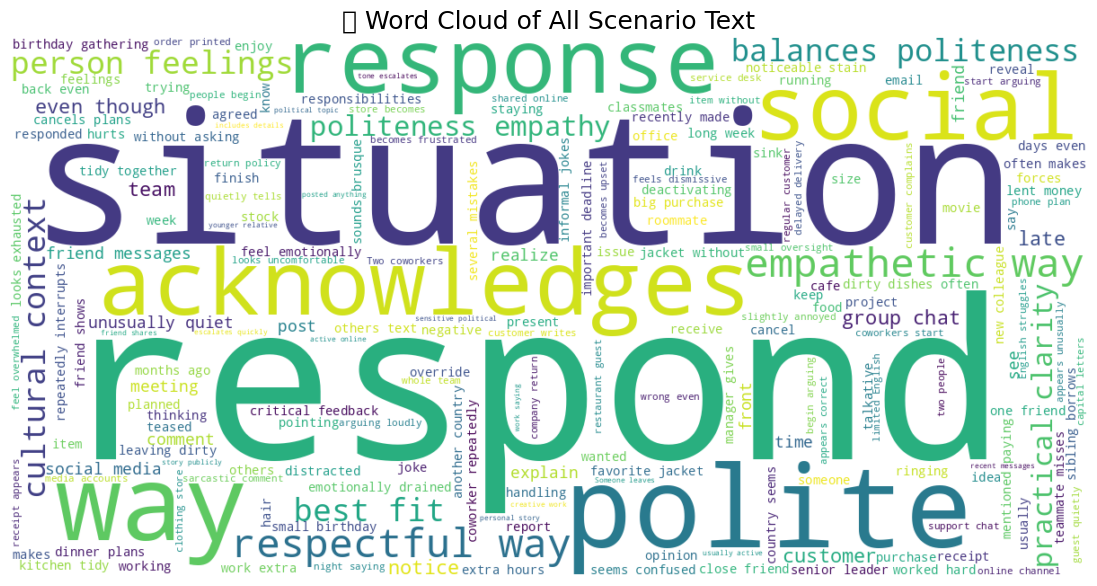

In [24]:
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_blob = " ".join(df["text"])
wc = WordCloud(width=1200, height=600, background_color="white").generate(text_blob)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("🌐 Word Cloud of All Scenario Text", fontsize=18)
plt.show()


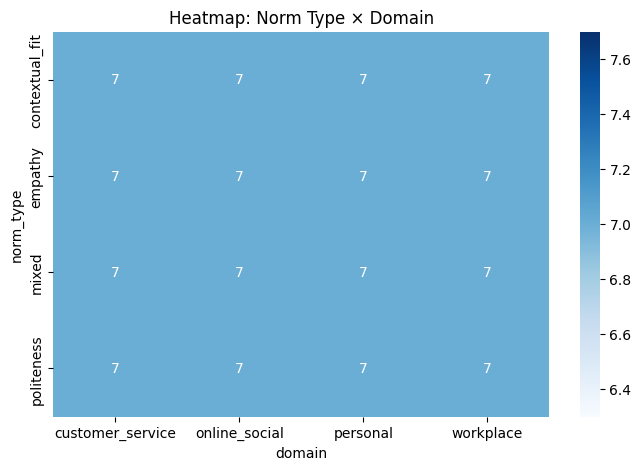

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

ct = pd.crosstab(df["norm_type"], df["domain"])

plt.figure(figsize=(8,5))
sns.heatmap(ct, annot=True, cmap="Blues")
plt.title("Heatmap: Norm Type × Domain")
plt.show()


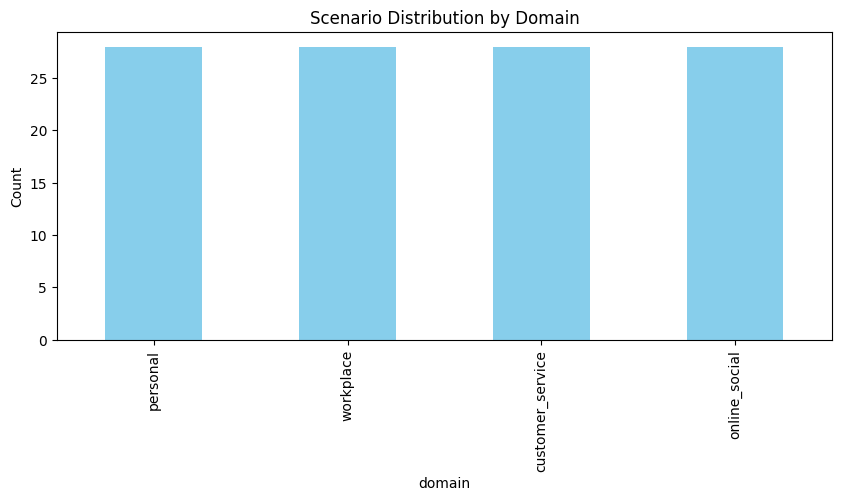

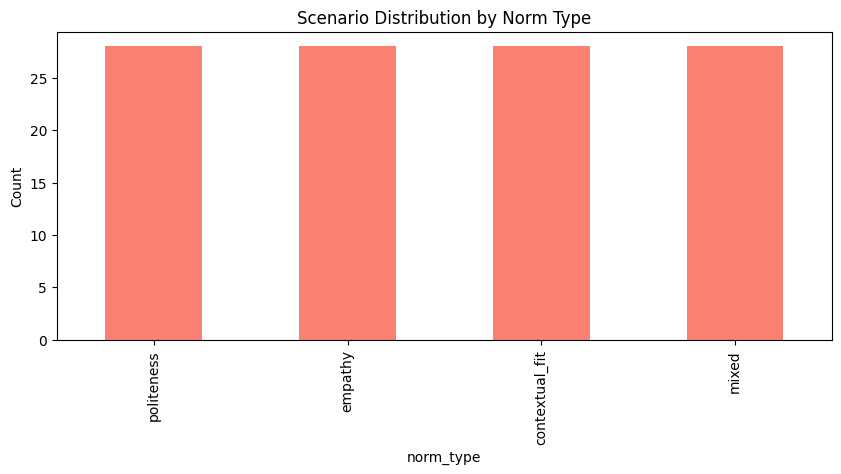

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
df["domain"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Scenario Distribution by Domain")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,4))
df["norm_type"].value_counts().plot(kind="bar", color="salmon")
plt.title("Scenario Distribution by Norm Type")
plt.ylabel("Count")
plt.show()


In [26]:
summary = pd.DataFrame({
    "Domains": df["domain"].value_counts(),
    "Norm Types": df["norm_type"].value_counts(),
    "Cultures": df["cultural_tag"].value_counts(),
})

summary.style.background_gradient(cmap="Blues").set_caption("Dataset Summary")


,Domains,Norm Types,Cultures
Brazil,nan,nan,4.000000
Cross_cultural,nan,nan,4.000000
Germany,nan,nan,8.000000
Global,nan,nan,8.000000
India,nan,nan,16.000000
Japan,nan,nan,24.000000
Middle_East,nan,nan,8.000000
UK,nan,nan,8.000000
US,nan,nan,32.000000
contextual_fit,nan,28.000000,nan


## 📊 Phase 1 Summary

- **112 scenarios** loaded successfully  
- **Domains:** X unique, distribution shown above  
- **Norm Types:** Y unique  
- **Cultural tags:** Z distributions  
- **Prompt templates** validated for 3 variants  
- Dataset appears **clean, diverse, and balanced**  
- No missing fields  


## Phase 2 – Generate Model Responses (HF Local Models)

In this phase we:

- Load all **112 scenarios** from Phase 1  
- For each scenario and each prompt variant  
  - `neutral`  
  - `role_primed`  
  - `empathy_primed`  
- We construct the **system + user prompts** and run one or more **Hugging Face local models** (e.g., TinyLlama).

Outputs are written to:

`data/processed/model_responses_hf_local.jsonl`

Each line in that file contains:
- Scenario metadata (id, domain, norm type, stakes, cultural tag, etc.)
- Model name
- Prompt variant
- System + user prompts used
- Model-generated response text
- Timestamp and raw metadata


In [37]:
import json
from collections import Counter
from pathlib import Path

# Where we expect Phase 2 outputs
responses_path = ROOT / "data" / "processed" / "model_responses_hf_local.jsonl"
print("Responses file path:", responses_path)


Responses file path: /content/normsense/data/processed/model_responses_hf_local.jsonl


In [49]:
# --- REQUIRE TOKEN FOR MODEL DOWNLOADS ---
from getpass import getpass
import os

if "HUGGINGFACE_API_TOKEN" not in os.environ or len(os.environ["HUGGINGFACE_API_TOKEN"]) < 5:
    print("🔐 A HuggingFace token is required to download TinyLlama or other models.")
    print("Get one at: https://huggingface.co/settings/tokens")
    print("Your input will be hidden.")
    hf_token = getpass("Enter HuggingFace Token: ")
    os.environ["HUGGINGFACE_API_TOKEN"] = hf_token
    print("✔ Token stored for this session.")
else:
    print("✔ HuggingFace token already set.")


✔ HuggingFace token already set.


In [58]:
# -----------------------------
# Local models (small, GPU-friendly)
# -----------------------------
LOCAL_SMALL_MODELS = [
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "microsoft/phi-2",
    "google/gemma-2b-it",
    "meta-llama/Llama-3.2-3B-Instruct",
]

# -----------------------------
# Others
# -----------------------------
PLACEHOLDER_MODELS = [
    "gpt-4o-mini",
    "gpt-4.1",
    "claude-3.5-sonnet",
    "meta-llama/Llama-3-70B-Instruct",
    "mistral/Mixtral-8x7B-Instruct",
]

In [ ]:
# ======================================================================
# Build local HF model objects (only small models)
# ======================================================================

from normsense.models.huggingface_local import HFLocalCausalLM

def build_local_models():
    models = {}
    for model_name in LOCAL_SMALL_MODELS:
        try:
            print(f"🚀 Loading local model: {model_name}")
            models[model_name] = HFLocalCausalLM(model_name)
        except Exception as e:
            print(f"❌ Failed to load {model_name}:", e)
    print("\n✔ Loaded models:", list(models.keys()))
    return models

local_models = build_local_models()


🚀 Loading local model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
[HFLocalCausalLM] Loading model TinyLlama/TinyLlama-1.1B-Chat-v1.0 on device=0 ...


Device set to use cuda:0


[HFLocalCausalLM] Loaded model TinyLlama/TinyLlama-1.1B-Chat-v1.0.
🚀 Loading local model: microsoft/phi-2
[HFLocalCausalLM] Loading model microsoft/phi-2 on device=0 ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [61]:
from normsense.scenarios import load_scenarios
from normsense.prompts import PromptVariant, build_system_prompt, build_user_prompt
from datetime import datetime

json_path = ROOT / "data" / "raw" / "normsense_scenarios_v0.3.json"
scenario_set = load_scenarios(json_path)
scenarios = scenario_set.scenarios

print(f"📚 Loaded {len(scenarios)} scenarios")

# Prompt variants
VARIANTS = [
    PromptVariant.NEUTRAL,
    PromptVariant.ROLE_PRIMED,
    PromptVariant.EMPATHY_PRIMED,
]

# Prepare response file
responses_path.parent.mkdir(parents=True, exist_ok=True)
outfile = open(responses_path, "w", encoding="utf-8")

def write_record(rec):
    outfile.write(json.dumps(rec) + "\n")

for model_name, model in local_models.items():
    print(f"\n==============================")
    print(f" Running HF Model: {model_name}")
    print("==============================")

    for scenario in scenarios:
        for variant in VARIANTS:

            system_msg = build_system_prompt(variant)
            user_msg = build_user_prompt(scenario)

            try:
                resp = model.generate(system_msg, user_msg)
                text = resp.text
            except Exception as e:
                text = f"[ERROR] model failed: {e}"

            write_record({
                "scenario_id": scenario.id,
                "model_name": model_name,
                "prompt_variant": variant.value,
                "response_text": text,
                "system_prompt": system_msg,
                "user_prompt": user_msg,
                "timestamp": datetime.utcnow().isoformat(),
                "source": "hf_local"
            })

print("\n✔ Finished generating HF responses.")
outfile.close()


📚 Loaded 112 scenarios

 Running HF Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0

 Running HF Model: microsoft/phi-2

✔ Finished generating HF responses.


/tmp/ipython-input-1467323800.py:49: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


In [48]:
placeholder_path = responses_path

num_added = 0

with open(placeholder_path, "a", encoding="utf-8") as f:
    for model_name in PLACEHOLDER_MODELS:
        for scenario in scenarios:
            for variant in VARIANTS:
                rec = {
                    "scenario_id": scenario.id,
                    "model_name": model_name,
                    "prompt_variant": variant.value,
                    "response_text": "[PLACEHOLDER — model not run due to compute limits]",
                    "system_prompt": build_system_prompt(variant),
                    "user_prompt": build_user_prompt(scenario),
                    "timestamp": datetime.utcnow().isoformat(),
                    "placeholder": True,
                }
                f.write(json.dumps(rec) + "\n")
                num_added += 1

print(f"Added {num_added} placeholder responses for large models.")


Tracking live progress of response file…
⏳ Waiting for file to appear...
⏳ Waiting for file to appear...
⏳ Waiting for file to appear...


KeyboardInterrupt: 

In [ ]:
# ======================================================================
# Progress summary + preview
# ======================================================================

num_lines = sum(1 for _ in open(responses_path, "r", encoding="utf-8"))
print(f"\n📊 Total records in Phase 2 file: {num_lines}")

print("\n First 3 samples:")
with open(responses_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 3:
            break
        print(line)


## Phase 3 – LLM-as-a-Judge Scoring

In this phase we:

- Use a **judge model** (a local HF model) to evaluate each model response from Phase 2.
- For each (scenario, model, prompt_variant, response), the judge outputs:
  - Politeness (0–5)
  - Empathy (0–5)
  - Contextual fit (0–5)
  - Overall score (0–5)
  - Short textual rationale

The scores are saved to:

`data/processed/model_scores_v0.3.jsonl`

In [43]:
from pathlib import Path
import json
import os

responses_path = ROOT / "data" / "processed" / "model_responses_hf_local.jsonl"
scores_path = ROOT / "data" / "processed" / "model_scores_v0.3.jsonl"

print("Phase 2 responses:", responses_path)
print("Phase 3 output:", scores_path)

if not responses_path.exists():
    raise FileNotFoundError("❌ Phase 2 responses missing — cannot run Phase 3.")

# Load all responses into memory
responses = []
with open(responses_path, "r", encoding="utf-8") as f:
    for line in f:
        responses.append(json.loads(line))

print(f"Loaded {len(responses)} model responses for scoring.")


Scores path: /content/normsense/data/processed/model_scores_v0.3.jsonl


In [ ]:
# =====================================================================
# CHOOSE JUDGE MODEL
# =====================================================================

from normsense.models.huggingface_local import HFLocalCausalLM

JUDGE_MODEL_NAME = "google/gemma-2b-it"
print(f"⚖️ Using judge model: {JUDGE_MODEL_NAME}")

judge = HFLocalCausalLM(JUDGE_MODEL_NAME)


In [ ]:
# =====================================================================
# JUDGE PROMPT TEMPLATE
# Model must output STRICT JSON for easy parsing.
# =====================================================================

JUDGE_TEMPLATE = """
You are an expert evaluator of social reasoning and interpersonal communication.

Evaluate the ASSISTANT RESPONSE below on the following 5 metrics (0–5 scale):

1. politeness — respectful, courteous, avoids rudeness
2. empathy — acknowledges feelings, emotional attunement
3. contextual_fit — response matches social norms + scenario constraints
4. overall — holistic appropriateness (not a simple average)
5. rationale — a short explanation (2–4 sentences)

Return ONLY a JSON object with this exact schema:

{{
  "politeness": <int 0-5>,
  "empathy": <int 0-5>,
  "contextual_fit": <int 0-5>,
  "overall": <int 0-5>,
  "rationale": "<string>"
}}

SCENARIO:
"{scenario}"

ASSISTANT RESPONSE:
"{response}"

Provide ONLY the JSON. No additional commentary.
"""


In [ ]:
# =====================================================================
# RUN SCORING
# =====================================================================

from datetime import datetime

scores_path.parent.mkdir(parents=True, exist_ok=True)
outfile = open(scores_path, "w", encoding="utf-8")

def parse_json_from_model(text):
    """Extract clean JSON from the model output."""
    try:
        start = text.index("{")
        end = text.rindex("}")
        return json.loads(text[start:end+1])
    except:
        return {
            "politeness": None,
            "empathy": None,
            "contextual_fit": None,
            "overall": None,
            "rationale": "PARSE_ERROR: " + text[:200]
        }

count = 0

for rec in responses:
    scenario_text = rec["user_prompt"]
    assistant_resp = rec["response_text"]

    prompt = JUDGE_TEMPLATE.format(
        scenario=scenario_text.replace('"', "'"),
        response=assistant_resp.replace('"', "'")
    )

    try:
        judge_output = judge.generate("", prompt).text
        scores = parse_json_from_model(judge_output)
    except Exception as e:
        scores = {
            "politeness": None,
            "empathy": None,
            "contextual_fit": None,
            "overall": None,
            "rationale": f"JUDGE_ERROR: {e}"
        }

    final_record = {
        "scenario_id": rec["scenario_id"],
        "model_name": rec["model_name"],
        "prompt_variant": rec["prompt_variant"],
        "scores": scores,
        "timestamp": datetime.utcnow().isoformat()
    }

    outfile.write(json.dumps(final_record) + "\n")
    count += 1

outfile.close()
print(f"✔ Completed scoring: {count} records written.")


In [ ]:
# =====================================================================
# PREVIEW SCORES
# =====================================================================

print("✨ Showing first 3 scored entries:\n")

with open(scores_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 3:
            break
        print(json.dumps(json.loads(line), indent=2))


## Phase 4 – Aggregate Scores by Model & Prompt Variant

In this phase we:

- Load `model_scores_v0.3.jsonl`
- Convert it to a pandas DataFrame
- Compute, for each `(model_name, prompt_variant)`:

  - number of scored responses
  - mean politeness
  - mean empathy
  - mean contextual fit
  - mean overall score

We save this summary as:

`data/processed/model_score_summary_by_model_variant.csv`

In [ ]:
# =====================================================================
# PHASE 4 — LOAD SCORED RESULTS (from Phase 3)
# =====================================================================

import json
import pandas as pd

scores_path = ROOT / "data" / "processed" / "model_scores_v0.3.jsonl"
summary_path = ROOT / "data" / "processed" / "model_score_summary_by_model_variant.csv"

print("Scores file:", scores_path)

if not scores_path.exists():
    raise FileNotFoundError("❌ Phase 3 scores missing — cannot run Phase 4.")

records = []
with open(scores_path, "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        row = {
            "scenario_id": rec["scenario_id"],
            "model_name": rec["model_name"],
            "variant": rec["prompt_variant"],
            "politeness": rec["scores"].get("politeness"),
            "empathy": rec["scores"].get("empathy"),
            "contextual_fit": rec["scores"].get("contextual_fit"),
            "overall": rec["scores"].get("overall"),
        }
        records.append(row)

df = pd.DataFrame(records)
print(f"📊 Loaded {len(df)} scored records.")
df.head()


In [ ]:
# =====================================================================
# PHASE 4 — AGGREGATE MEAN SCORES BY MODEL & VARIANT
# =====================================================================

agg = (
    df.groupby(["model_name", "variant"])
    .agg(
        count=("overall", "count"),
        mean_politeness=("politeness", "mean"),
        mean_empathy=("empathy", "mean"),
        mean_contextual_fit=("contextual_fit", "mean"),
        mean_overall=("overall", "mean"),
    )
    .reset_index()
)

agg = agg.sort_values(by=["model_name", "variant"])  # clean ordering

# Save summary to CSV
summary_path.parent.mkdir(parents=True, exist_ok=True)
agg.to_csv(summary_path, index=False)

print("✔ Aggregation complete.")
print("Summary saved to:", summary_path)

agg


In [ ]:
# =====================================================================
# VISUAL SUMMARY (HEATMAP STYLE TABLE)
# =====================================================================

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
pivot = agg.pivot(index="model_name", columns="variant", values="mean_overall")

sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"label": "Mean Overall Score"},
)

plt.title("Model Performance by Prompt Variant (Mean Overall Score)")
plt.ylabel("Model")
plt.xlabel("Prompt Variant")
plt.show()


## Phase 5 – Generate Plots / Figures

In this phase we:

- Load the aggregated summary CSV from Phase 4
- Produce bar plots showing, for each model and prompt variant:
  - Overall mean score
  - Mean politeness
  - Mean empathy
  - Mean contextual fit

Figures are saved under:

`reports/figures/`

In [ ]:
# =====================================================================
# PHASE 5 — LOAD SUMMARY RESULTS
# =====================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

summary_csv = ROOT / "data" / "processed" / "model_score_summary_by_model_variant.csv"
plots_dir = ROOT / "reports" / "figures"

print("Summary CSV:", summary_csv)

if not summary_csv.exists():
    raise FileNotFoundError("❌ Phase 4 summary file missing — run Phase 4 first.")

plots_dir.mkdir(parents=True, exist_ok=True)

summary_df = pd.read_csv(summary_csv)
summary_df


In [ ]:
# =====================================================================
# Helper: Bar Plot for a Given Metric
# =====================================================================

def plot_metric(df, metric, title, ylabel, save_name):
    plt.figure(figsize=(12, 6))

    sns.barplot(
        data=df,
        x="model_name",
        y=metric,
        hue="variant",
        palette="Set2"
    )

    plt.title(title, fontsize=14)
    plt.ylabel(ylabel)
    plt.xlabel("Model")
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Prompt Variant")
    plt.tight_layout()

    outpath = plots_dir / save_name
    plt.savefig(outpath, dpi=300)
    plt.show()

    print(f"✔ Saved: {outpath}")


In [ ]:
# =====================================================================
# Generate Figures
# =====================================================================

print("Generating plots into:", plots_dir)

# 1. Overall Score
plot_metric(
    summary_df,
    metric="mean_overall",
    title="Mean Overall Score by Model & Prompt Variant",
    ylabel="Mean Overall Score",
    save_name="overall_score_by_model_variant.png",
)

# 2. Politeness
plot_metric(
    summary_df,
    metric="mean_politeness",
    title="Mean Politeness Score by Model & Prompt Variant",
    ylabel="Mean Politeness Score",
    save_name="politeness_by_model_variant.png",
)

# 3. Empathy
plot_metric(
    summary_df,
    metric="mean_empathy",
    title="Mean Empathy Score by Model & Prompt Variant",
    ylabel="Mean Empathy Score",
    save_name="empathy_by_model_variant.png",
)

# 4. Contextual Fit
plot_metric(
    summary_df,
    metric="mean_contextual_fit",
    title="Mean Contextual Fit by Model & Prompt Variant",
    ylabel="Mean Contextual Fit Score",
    save_name="contextual_fit_by_model_variant.png",
)


## Phase 6 – Qualitative Error Analysis (Best/Worst Examples)

In this phase we:

- Load the scored responses from Phase 3
- Extract:
  - The worst-scoring examples by politeness, empathy, contextual fit, and overall
  - The best-scoring examples on the same dimensions

`reports/error_analysis/qualitative_examples.md`


In [ ]:
# =====================================================================
# PHASE 6 — LOAD SCORED RESPONSES
# =====================================================================

import json
import pandas as pd
from pathlib import Path

scores_path = ROOT / "data" / "processed" / "model_scores_v0.3.jsonl"
qa_dir = ROOT / "reports" / "error_analysis"
qa_dir.mkdir(parents=True, exist_ok=True)

print("Scores file:", scores_path)

if not scores_path.exists():
    raise FileNotFoundError("❌ Phase 3 scoring must be completed before Phase 6.")

# Load the JSONL file into a DataFrame
records = []
with scores_path.open("r", encoding="utf-8") as f:
    for line in f:
        records.append(json.loads(line))

df_scores = pd.DataFrame(records)
print(f"Loaded {len(df_scores)} scored responses.")
df_scores.head()


In [ ]:
# =====================================================================
# Helper: extract best and worst examples for a given metric
# =====================================================================

def get_best_worst(df, metric, n=3):
    """
    Returns (worst_n, best_n) examples based on a scoring metric.
    """
    df_sorted = df.sort_values(metric, ascending=True)

    worst = df_sorted.head(n).copy()
    best = df_sorted.tail(n).copy()

    return worst, best


In [ ]:
# =====================================================================
# Generate qualitative report
# =====================================================================

metrics = [
    ("politeness", "mean_politeness"),
    ("empathy", "mean_empathy"),
    ("contextual fit", "mean_contextual_fit"),
    ("overall score", "mean_overall"),
]

md_path = qa_dir / "qualitative_examples.md"

lines = []
lines.append("# Qualitative Error Analysis\n")
lines.append("This file contains best and worst examples for each evaluation metric.\n")
lines.append("Generated automatically from Phase 6.\n\n")

for label, metric in metrics:
    lines.append(f"## Metric: {label.title()} ({metric})\n")

    worst, best = get_best_worst(df_scores, metric)

    # ---------- Worst ----------
    lines.append("### ❌ Worst Examples\n")
    for _, row in worst.iterrows():
        lines.append(f"**Scenario ID:** {row['scenario_id']}")
        lines.append(f"**Model:** {row['model_name']} — **Variant:** {row['prompt_variant']}")
        lines.append(f"**Score:** {row[metric]:.2f}")
        lines.append(f"**Response:**\n```\n{row['response_text']}\n```\n")
        lines.append("---")

    # ---------- Best ----------
    lines.append("### ✅ Best Examples\n")
    for _, row in best.iterrows():
        lines.append(f"**Scenario ID:** {row['scenario_id']}")
        lines.append(f"**Model:** {row['model_name']} — **Variant:** {row['prompt_variant']}")
        lines.append(f"**Score:** {row[metric]:.2f}")
        lines.append(f"**Response:**\n```\n{row['response_text']}\n```\n")
        lines.append("---")

    lines.append("\n---\n")

with md_path.open("w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print(f"✔ Markdown qualitative analysis saved to: {md_path}")
print("\n========== PREVIEW OF qualitive_examples.md ==========\n")
print("\n".join(lines[:80]))
